In [2]:
!pip install transformers datasets -q

In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
from google.colab import files
uploaded = files.upload()

Saving sentiment140.csv to sentiment140.csv
Saving twitch_reviews.csv to twitch_reviews.csv


In [9]:
twitch_df = pd.read_csv("twitch_reviews.csv")
twitch_df = twitch_df[['content']]

# Sentiment140 dataset
senti_df = pd.read_csv("sentiment140.csv", encoding='latin-1', header=None)
senti_df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
senti_df = senti_df[['text', 'target']]
senti_df['target'] = senti_df['target'].map({0: 0, 2: 1, 4: 2})

In [51]:
twitch_sample = twitch_df.sample(n=1000, random_state=42).reset_index(drop=True)

twitch_sample = twitch_sample[twitch_sample['content'].str.len() > 20]
twitch_sample.reset_index(drop=True, inplace=True)

In [52]:
from transformers import BertTokenizer, BertForSequenceClassification

In [53]:
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use cuda:0


In [54]:
sentiments = []
for text in twitch_sample['content']:
    result = classifier(text[:512])[0]
    sentiments.append(int(result['label'][0]))

twitch_sample['sentiment_score'] = sentiments

In [55]:
np.random.seed(42)

In [56]:
twitch_sample['bitrate'] = np.random.randint(2000, 8000, size=len(twitch_sample))
twitch_sample['latency'] = np.random.randint(20, 120, size=len(twitch_sample))
twitch_sample['resolution'] = np.random.choice([480, 720, 1080, 1440], size=len(twitch_sample))
twitch_sample['frame_rate'] = np.random.choice([30, 60], size=len(twitch_sample))

In [63]:
noise = np.random.normal(0, 0.5, size=len(twitch_sample))
twitch_sample['noisy_score'] = twitch_sample['sentiment_score'] + noise
twitch_sample['satisfaction'] = (twitch_sample['noisy_score'] >= 4).astype(int)

In [66]:
from sklearn.utils import resample

minority_class = twitch_sample['satisfaction'].value_counts().idxmin()
majority_class = 1 - minority_class

df_minority = twitch_sample[twitch_sample.satisfaction == minority_class]
df_majority = twitch_sample[twitch_sample.satisfaction == majority_class]

# Downsample majority to match minority size
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

# Combine
twitch_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

In [69]:
features = twitch_balanced[['sentiment_score', 'bitrate', 'latency', 'resolution', 'frame_rate']]
labels = twitch_balanced['satisfaction']

In [70]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

In [72]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [73]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_split=0.2)

Epoch 1/15
30/30 [==============================] - 1s 9ms/step - loss: 0.5592 - accuracy: 0.7591 - val_loss: 0.4479 - val_accuracy: 0.8974
Epoch 2/15
30/30 [==============================] - 0s 5ms/step - loss: 0.3948 - accuracy: 0.9075 - val_loss: 0.3184 - val_accuracy: 0.9060
Epoch 3/15
30/30 [==============================] - 0s 5ms/step - loss: 0.2945 - accuracy: 0.9075 - val_loss: 0.2528 - val_accuracy: 0.9145
Epoch 4/15
30/30 [==============================] - 0s 4ms/step - loss: 0.2455 - accuracy: 0.9032 - val_loss: 0.2215 - val_accuracy: 0.9231
Epoch 5/15
30/30 [==============================] - 0s 4ms/step - loss: 0.2236 - accuracy: 0.9032 - val_loss: 0.2052 - val_accuracy: 0.9231
Epoch 6/15
30/30 [==============================] - 0s 4ms/step - loss: 0.2156 - accuracy: 0.9054 - val_loss: 0.2059 - val_accuracy: 0.9145
Epoch 7/15
30/30 [==============================] - 0s 5ms/step - loss: 0.2073 - accuracy: 0.9118 - val_loss: 0.1968 - val_accuracy: 0.9231
Epoch 8/15
30/30 [==

In [75]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.2f}")

5/5 [==============================] - 0s 4ms/step - loss: 0.2043 - accuracy: 0.9110

Test Accuracy: 0.91


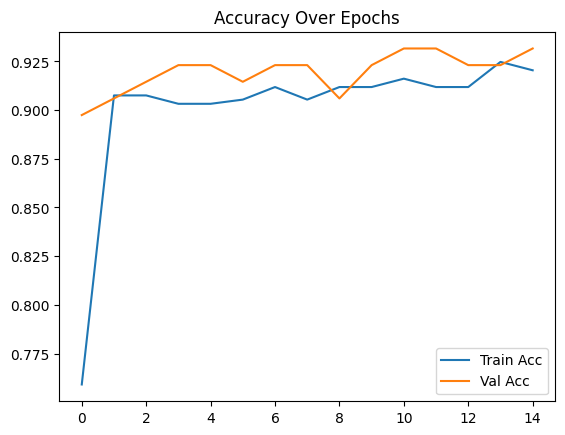

In [76]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

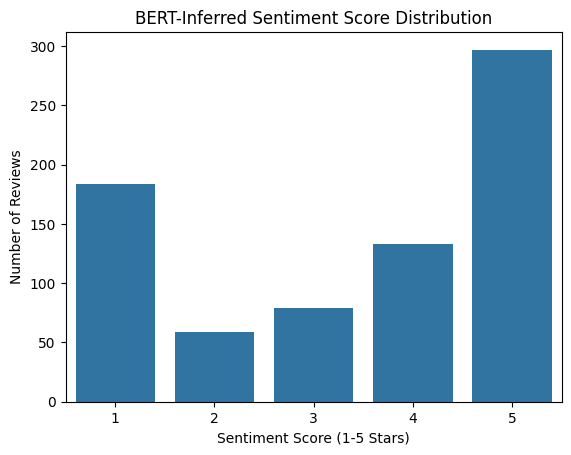

In [77]:
import seaborn as sns

sns.countplot(x='sentiment_score', data=twitch_sample)
plt.title("BERT-Inferred Sentiment Score Distribution")
plt.xlabel("Sentiment Score (1-5 Stars)")
plt.ylabel("Number of Reviews")
plt.show()

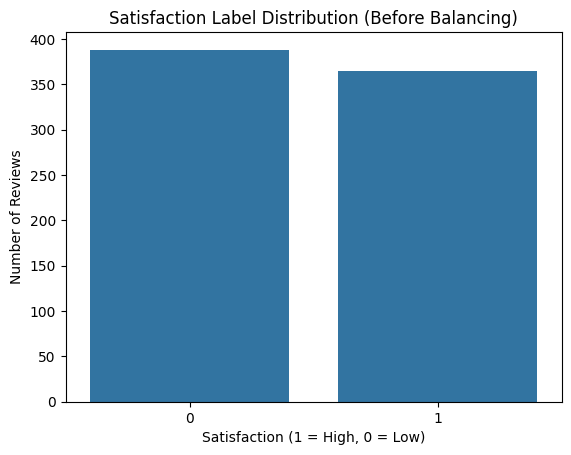

In [78]:
sns.countplot(x='satisfaction', data=twitch_sample)
plt.title("Satisfaction Label Distribution (Before Balancing)")
plt.xlabel("Satisfaction (1 = High, 0 = Low)")
plt.ylabel("Number of Reviews")
plt.show()

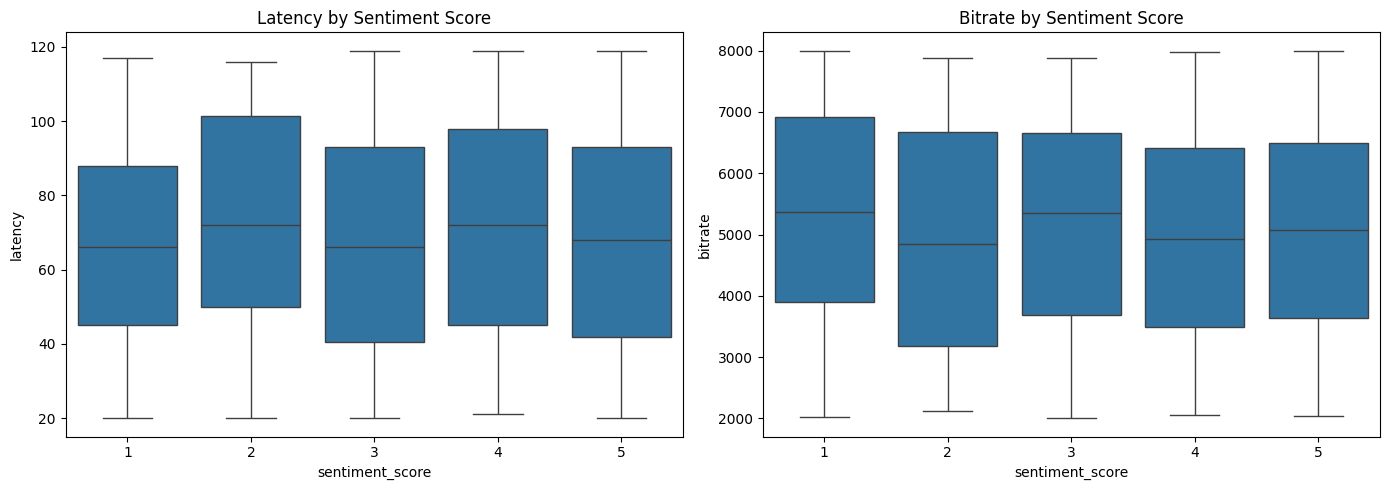

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x='sentiment_score', y='latency', data=twitch_sample, ax=axes[0])
axes[0].set_title("Latency by Sentiment Score")
sns.boxplot(x='sentiment_score', y='bitrate', data=twitch_sample, ax=axes[1])
axes[1].set_title("Bitrate by Sentiment Score")
plt.tight_layout()
plt.show()

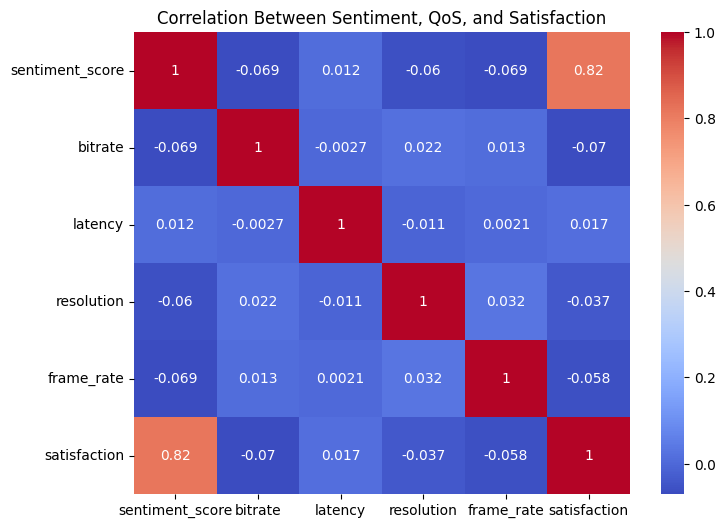

In [80]:
plt.figure(figsize=(8,6))
sns.heatmap(twitch_sample[['sentiment_score', 'bitrate', 'latency', 'resolution', 'frame_rate', 'satisfaction']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Sentiment, QoS, and Satisfaction")
plt.show()

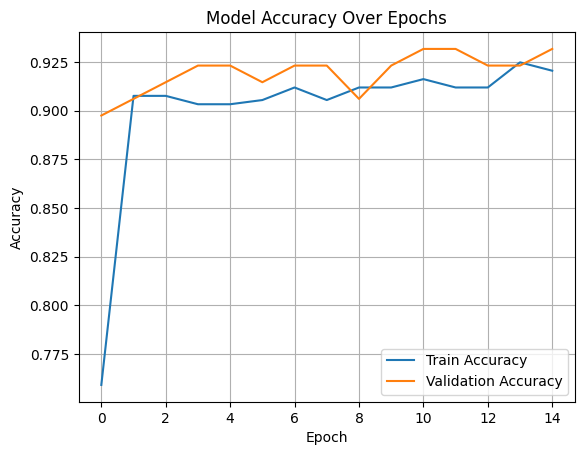

In [81]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()